# **install and import**

In [3]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [4]:

import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ResizeWithPadOrCropd,
    SpatialCrop
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR,SwinUNETR,UNet

from monai.data import (
    CacheDataset,
    DataLoader,
    Dataset,
    load_decathlon_datalist,
    decollate_batch,
)

from monai.networks.layers import Norm
import torch

print_config()

MONAI version: 1.2.dev2312
Numpy version: 1.21.6
Pytorch version: 1.11.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 400a6a052f1b2925db6f1323a67a7cf4546403eb
MONAI __file__: /opt/conda/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.1.1
Tensorboard version: 2.6.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.12.0
tqdm version: 4.64.0
lmdb version: 1.4.0
psutil version: 5.9.1
pandas version: 1.3.5
einops version: 0.6.1
transformers version: 4.20.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies




# **Data Preparation**

I want to upload the images to the cache for faster training. To achieve this, I have excluded images that contain more than 450 slices.

In [5]:

import nibabel as nib
#image list
img_files=[os.path.join(path[0],file) for path in os.walk('/kaggle/input/')   for file in path[-1]  if 'pt' in path[0] if 'vol' in file]  
len(img_files)
img_files_for_trainig=[]
for file in img_files:
    n1_img_sh = nib.load(file).header.get_data_shape()
 
    if     n1_img_sh[2]<450 :
        img_files_for_trainig.append(file)
 

In [6]:
len(img_files_for_trainig)

67

In [7]:
#segmentaim list
seg_path='/kaggle/input/liver-tumor-segmentation/segmentations/'


seg_files=[seg_path+'segmentation-'+file.split('-')[-1] for file in img_files_for_trainig]  
print(img_files_for_trainig[2],seg_files[2])

/kaggle/input/liver-tumor-segmentation/volume_pt3/volume-30.nii /kaggle/input/liver-tumor-segmentation/segmentations/segmentation-30.nii


In [8]:
#monai dataset need dictonary
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(img_files_for_trainig, seg_files)]
train_files, val_files,test_files = data_dicts[:-17], data_dicts[-17:-10],data_dicts[-7:]

In [9]:
n1_img_sh = nib.load(data_dicts[0]['image'])#.header.get_data_shape()
data = n1_img_sh.get_fdata()

data.shape

(512, 512, 276)

# **Setup transforms for training and validation**

https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d_visualization_basic.ipynb

https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/unetr_btcv_segmentation_3d.ipynb



Here we use several transforms to augment the dataset:

    LoadImaged loads the liver CT images and labels from NIfTI format files.
    EnsureChannelFirstd ensures the original data to construct "channel first" shape.
    Spacingd adjusts the spacing by pixdim=(1.5, 1.5, 2.) based on the affine matrix.
    Orientationd unifies the data orientation based on the affine matrix.
    ScaleIntensityRanged extracts intensity range [-57, 164] and scales to [0, 1].
    CropForegroundd removes all zero borders to focus on the valid body area of the images and labels.
    
    RandCropByPosNegLabeld randomly crop patch samples from big image based on pos / neg ratio.

The image centers of negative samples must be in valid body area.

    RandAffined efficiently performs rotate, scale, shear, translate, etc. together based on PyTorch affine transform.
    EnsureTyped converts the numpy array to PyTorch Tensor for further steps.

In [10]:
class ToLiver(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        label[label==2]=1
        return {'image': image,
                'label': label}

In [11]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),

        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(128,128, 32), #64
            pos=1,
            neg=1,
            num_samples=10,
            image_key="image",
            image_threshold=0,
        ),

        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        )
    ]
)

/opt/conda/lib/python3.7/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


In [12]:
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),

        ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

In [13]:
#create data set with the transform for the train and val


train_ds =CacheDataset(
    data=train_files,
    transform=train_transforms,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)



Loading dataset: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it]


In [14]:
val_ds =Dataset(
    data=val_files,
    transform=val_transforms,
)

image shape: torch.Size([1, 512, 512, 245]), label shape: torch.Size([1, 512, 512, 245])


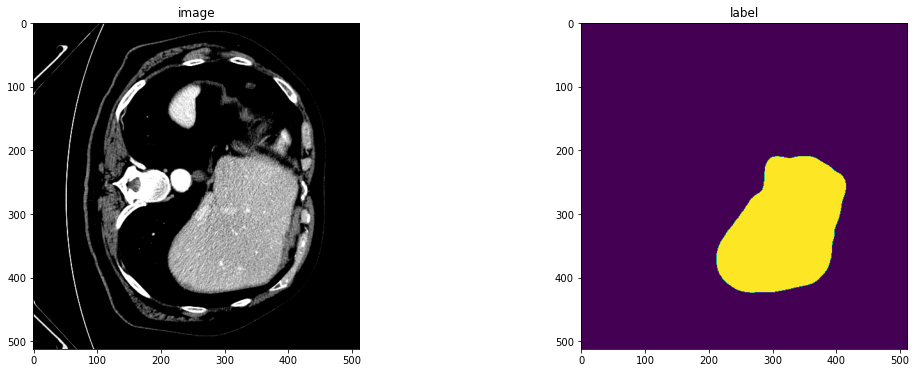

In [15]:
img = val_ds[0]["image"]
label = val_ds[0]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[ 0,:, :,-30].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, -30].detach().cpu())
plt.show()

torch.Size([1, 512, 512, 245])
[[177, 333, 178], [196, 317, 169], [264, 308, 194], [221, 335, 202], [170, 242, 196], [166, 313, 199], [237, 252, 181], [275, 200, 202], [156, 252, 208], [238, 215, 184]]


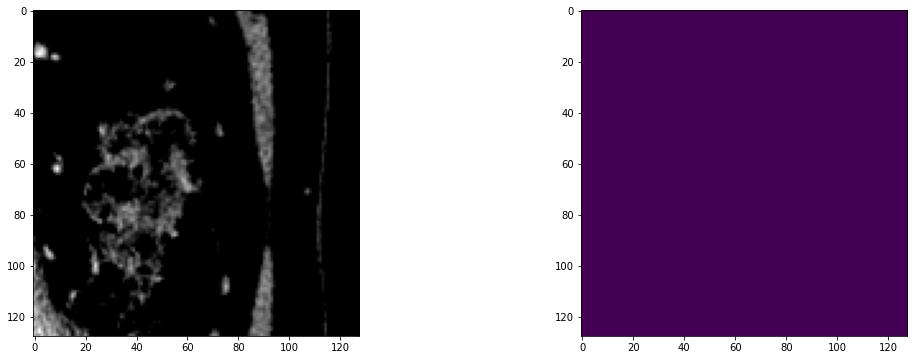

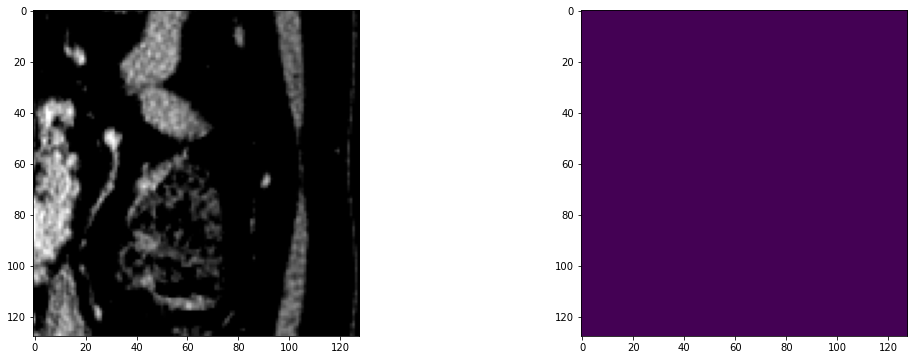

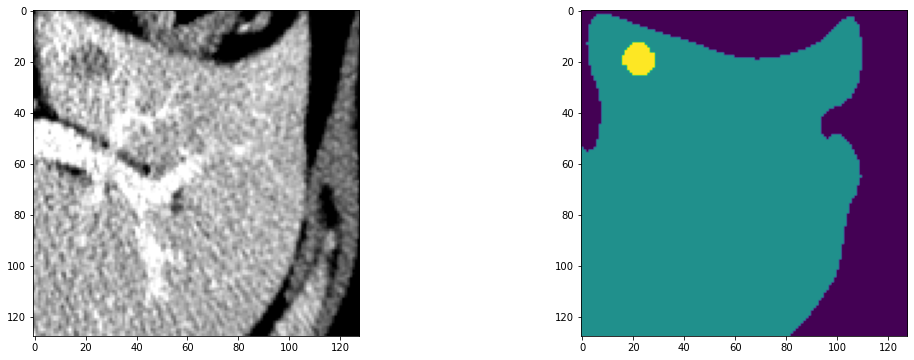

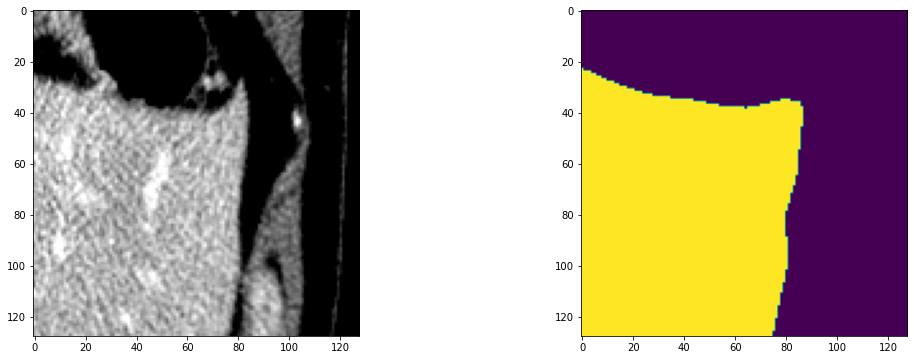

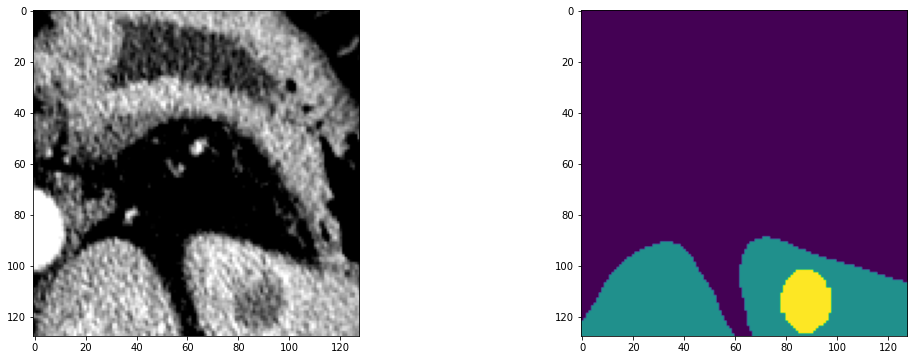

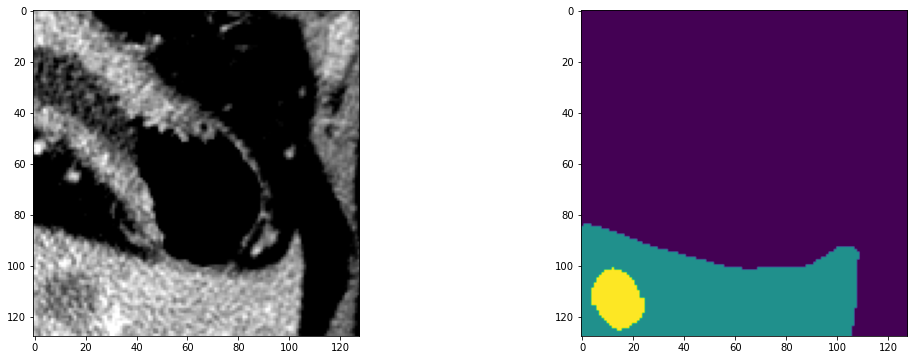

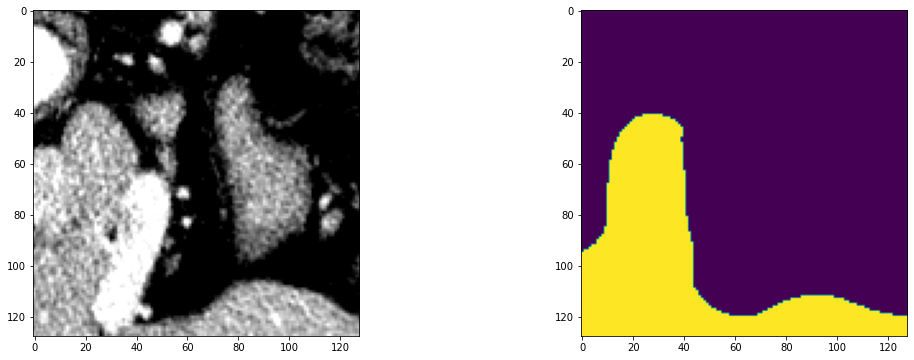

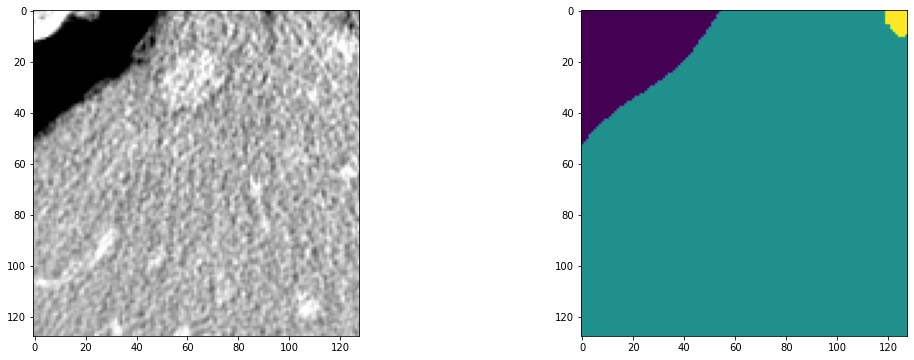

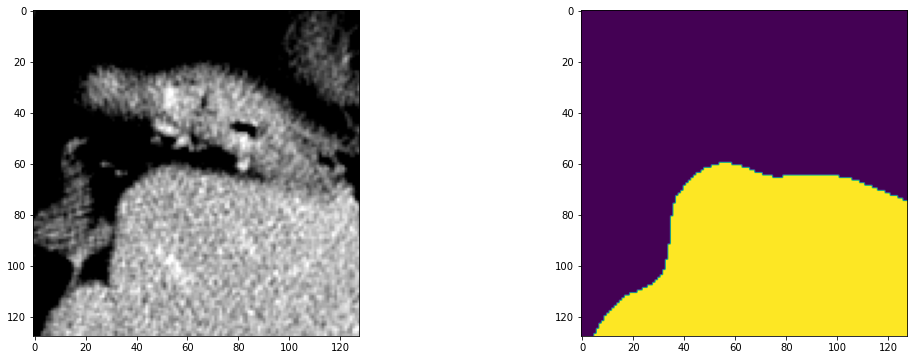

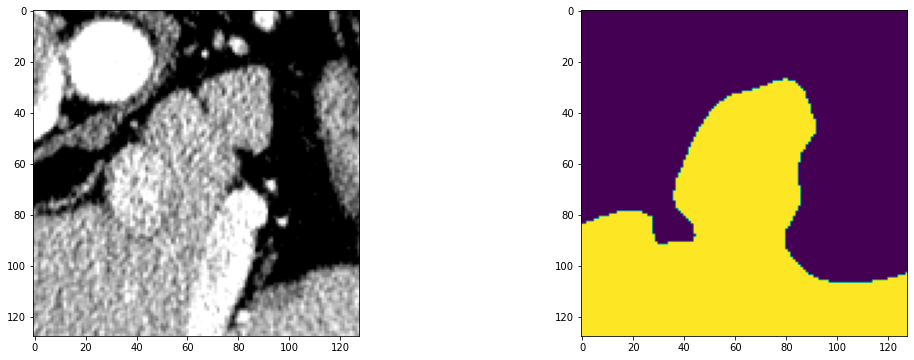

In [16]:
import numpy as np
from numpy import random
from monai.data import PatchDataset, DataLoader, PatchIter
inds=[]
def Crop_label(label):
    r=[]
    b=0
    liver=0
    tumor=0
    
    if label.shape[0]==1:
        label=label[0]
    x,y,z=label.shape
    while(tumor<10):
        i = random.randint(x-128)
        j = random.randint(y-128)
        k = random.randint(z-32)
        
       
        unique_num=np.unique(label[i:i+128,j:j+128,k:k+32])
        if 2 in unique_num and tumor<10:
            tumor=tumor+1
      
            inds.append([i,j,k])
        '''
        elif 2 not in unique_num and 1 in unique_num and liver<5:
            liver=liver+1
            inds.append([i,j,k])
        elif 2 not in unique_num and 1 not in unique_num and b<0:
            b=b+1
            inds.append([i,j,k])
       '''
    

    return  inds



def Crop_img(img):
    r=[]
    b=0
    liver=0
    tumor=0
    
    if img.shape[0]==1:
        img=img[0]
    x,y,z=img.shape
    for ind in inds:
        i,j,k=ind

        r.append(img[i:i+128,j:j+128,k:k+32])
         

    return r
            
# imaabsge-level dataset
img = val_ds[0]["image"]

print(img.shape)
label = val_ds[0]["label"]

# image patch sampler
n_samples = 10
# patch-level intensity shifts
# construct the patch dataset

inds=Crop_label(label)

ds_l = PatchDataset(data=label,
                  patch_func=Crop_img,
                  samples_per_image=n_samples)
print(inds)
ds_i = PatchDataset(data=img,
                  patch_func=Crop_img,
                  samples_per_image=n_samples)



val_loader1=DataLoader(ds_i, batch_size=1, shuffle=False, num_workers=1)
val_loader2=DataLoader(ds_l, batch_size=1, shuffle=False, num_workers=1)

#y=DataLoader(label_ds, batch_size=1, shuffle=False, num_workers=2)

for i,item1 in enumerate(zip(val_loader1,val_loader2)):
    plt.figure("image", (18, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(item1[0][0,:, :, 5].detach().cpu(), cmap="gray")
    plt.subplot(1, 2, 2)
    plt.imshow(item1[1][0,:, :, 5].detach().cpu())
    plt.show()



# **Check data shape and visualize**

In [17]:
from monai.networks.nets import TopologyInstance
from  monai.networks.nets import TopologySearch
from monai.networks.nets import AHNet,UNet,VNet
root_dir='/kaggle/working'
from monai.apps import load_from_mmar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# model=AHNet(layers=(2, 2,2,2), spatial_dims=3, in_channels=1, out_channels=3
#                                 , psp_block_num=1, upsample_mode='transpose', pretrained=True, progress=True).to(device)

# model=VNet(spatial_dims=3, in_channels=1, out_channels=3).to(device)
'''
arch_mode=torch.load('/kaggle/input/search-code/search_code_18590.pt')
dints_space=TopologyInstance(
     channel_mul=1.0, 
      num_blocks=12,
     num_depths=4, spatial_dims=3, act_name='RELU',
      use_downsample=True, 
    arch_code=[arch_mode['arch_code_a'],arch_mode['arch_code_c']]).to(device)

model = DiNTS(dints_space, 1, 3, act_name='RELU',
 #model               spatial_dims=3, use_downsample=True, 
                node_a= torch.from_numpy(arch_mode['node_a'])).to(device)

'''
model =UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels= (8,16,32,64),
    strides=(2,2,2),
).to(device)



#model=BasicUNetPlusPlus(spatial_dims=3, in_channels=1, out_channels=3).to(device)
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-4)



In [18]:


def validation(epoch_iterator_val):
    model.eval()
    val_labels_convert=[]
    val_outputs_convert=[]
    with torch.no_grad():
        for step,batch in enumerate(zip(val_loader1,val_loader2)):
            val_inputs,val_labels=batch
            val_inputs=val_inputs[None,:,:,:,:].cuda()
            val_labels=val_labels[ None,:, :,:,:].cuda()
            val_outputs = model(val_inputs)
            val_labels_convert.append(post_label(decollate_batch(val_labels)[0])[0])
            val_outputs_convert.append(post_pred(decollate_batch(val_outputs)[0])[0])
        dice_metric(y_pred=val_outputs_convert, y=val_labels_convert)
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    #model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader1, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print(
                        "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                    )
            else:
                    print(
                        "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                            dice_val_best, dice_val
                        )
                    )
        global_step += 1
    return global_step, dice_val_best, global_step_best

max_iterations = 2000
eval_num = 50

post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

#m''''''odel.load_state_dict(torch.load('/kaggle/input/model-liver2/best_metric_model.pth'))
#model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
max_epochs = 10  # Define the maximum number of epochs

# Iterate through epochs
# for epoch in range(max_epochs):
#     # Inside each epoch, perform the training steps
#     global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
#         # Log metrics to TensorBoard
#     writer.add_scalar('Dice Validation', dice_val_best, epoch)
#     writer.flush()



# # After completing the specified number of epochs, load the best model
# model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
# print(f"Training completed, best_metric: {dice_val_best:.4f} at iteration: {global_step_best}")

In [19]:
from monai.metrics import MeanIoU
# Create an instance of MeanIoU metric
iou_metric = MeanIoU(include_background=True, reduction="mean")

def validation_iou(epoch_iterator_val):
    model.eval()
    val_labels_convert=[]
    val_outputs_convert=[]
    with torch.no_grad():
        for step, batch in enumerate(zip(val_loader1,val_loader2)):
            val_inputs,val_labels=batch
            val_inputs=val_inputs[None,:,:,:,:].cuda()
            val_labels=val_labels[ None,:, :,:,:].cuda()
            val_outputs = model(val_inputs)
            val_labels_convert.append(post_label(decollate_batch(val_labels)[0])[0])
            val_outputs_convert.append(post_pred(decollate_batch(val_outputs)[0])[0])
        # Compute IoU scores
        iou_metric(y_pred=val_outputs_convert, y=val_labels_convert)
        mean_iou_val = iou_metric.aggregate().item()
        # Reset the metric for the next validation
        iou_metric.reset()
    return mean_iou_val

In [20]:
def train_iou(global_step, train_loader, iou_val_best, global_step_best):
    #model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader1, desc="Validate (X / X Steps) (iou=X.X)", dynamic_ncols=True)
            iou_val = validation_iou(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(iou_val)
            if iou_val > iou_val_best:
                iou_val_best = iou_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_iou_model.pth"))
                print(
                        "Model Was Saved ! Current Best Avg. IoU: {} Current Avg. IoU: {}".format(iou_val_best, iou_val)
                    )
            else:
                    print(
                        "Model Was Not Saved ! Current Best Avg. IoU: {} Current Avg. IoU: {}".format(
                            iou_val_best, iou_val
                        )
                    )
        global_step += 1
    return global_step, iou_val_best, global_step_best


In [21]:
# Set the maximum number of epochs
max_epochs = 10

# Initialize variables for tracking best IoU score and corresponding global step
iou_val_best = 0.0
global_step_best = 0

# Initialize lists to store epoch loss and IoU metric values
epoch_loss_values = []
iou_values = []

# # Iterate through epochs
# for epoch in range(max_epochs):
#     # Inside each epoch, perform the training steps
#     global_step, iou_val_best, global_step_best = train(global_step, train_loader, iou_val_best, global_step_best)
#     writer.add_scalar('IOU Validation', iou_val_best, epoch)
#     writer.flush()

# # After completing the specified number of epochs, load the best model
# model.load_state_dict(torch.load(os.path.join(root_dir, "best_iou_model.pth")))
# print(f"Training completed, best IoU: {iou_val_best:.4f} at iteration: {global_step_best}")


In [22]:
# Import the SummaryWriter from TensorBoard
from torch.utils.tensorboard import SummaryWriter

# Initialize SummaryWriter objects for Dice and IOU validation logs with different directories
dice_log_dir = "./logs_dice"
iou_log_dir = "./logs_iou"
dice_writer = SummaryWriter(dice_log_dir)
iou_writer = SummaryWriter(iou_log_dir)

# Inside your training loop, add the following lines to log the Dice score and IOU score to TensorBoard
for epoch in range(max_epochs):
    # Inside each epoch, perform the training steps
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
    dice_writer.add_scalar('Dice Validation', dice_val_best, epoch)
    dice_writer.flush()

    # Inside each epoch, perform the training steps for IOU as well
    global_step, iou_val_best, global_step_best = train_iou(global_step, train_loader, iou_val_best, global_step_best)
    iou_writer.add_scalar('IOU Validation', iou_val_best, epoch)
    iou_writer.flush()

# After completing the specified number of epochs, close the SummaryWriters
dice_writer.close()
iou_writer.close()

# After completing the specified number of epochs, load the best model for each metric
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
print(f"Training completed, best Dice: {dice_val_best:.4f} at iteration: {global_step_best}")

model.load_state_dict(torch.load(os.path.join(root_dir, "best_iou_model.pth")))
print(f"Training completed, best IOU: {iou_val_best:.4f} at iteration: {global_step_best}")


Training (50 / 2000 Steps) (loss=1.74676):   2%|▏         | 1/50 [00:02<01:52,  2.30s/it]

Model Was Saved ! Current Best Avg. IoU: 0.3410758972167969 Current Avg. IoU: 0.3410758972167969


Training (100 / 2000 Steps) (loss=1.70505):   2%|▏         | 1/50 [00:03<02:34,  3.15s/it]

Model Was Saved ! Current Best Avg. Dice: 0.603050947189331 Current Avg. Dice: 0.603050947189331


Training (150 / 2000 Steps) (loss=1.63859):   2%|▏         | 1/50 [00:03<02:27,  3.00s/it]

Model Was Saved ! Current Best Avg. IoU: 0.5436286926269531 Current Avg. IoU: 0.5436286926269531


Training (200 / 2000 Steps) (loss=1.57849):   2%|▏         | 1/50 [00:03<03:03,  3.75s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7896760702133179 Current Avg. Dice: 0.7896760702133179


Training (250 / 2000 Steps) (loss=1.51390):   2%|▏         | 1/50 [00:02<01:40,  2.06s/it]

Model Was Saved ! Current Best Avg. IoU: 0.6986812949180603 Current Avg. IoU: 0.6986812949180603


Training (300 / 2000 Steps) (loss=1.52977):   2%|▏         | 1/50 [00:03<02:49,  3.47s/it]

Model Was Saved ! Current Best Avg. Dice: 0.823992908000946 Current Avg. Dice: 0.823992908000946


Training (350 / 2000 Steps) (loss=1.47162):   2%|▏         | 1/50 [00:02<01:41,  2.06s/it]

Model Was Saved ! Current Best Avg. IoU: 0.7242826223373413 Current Avg. IoU: 0.7242826223373413


Training (400 / 2000 Steps) (loss=1.37576):   2%|▏         | 1/50 [00:03<02:35,  3.18s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8343183398246765 Current Avg. Dice: 0.8343183398246765


Training (450 / 2000 Steps) (loss=1.46293):   2%|▏         | 1/50 [00:02<01:58,  2.42s/it]

Model Was Saved ! Current Best Avg. IoU: 0.7431290745735168 Current Avg. IoU: 0.7431290745735168


Training (500 / 2000 Steps) (loss=1.43666):   2%|▏         | 1/50 [00:04<03:28,  4.26s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8377680778503418 Current Avg. Dice: 0.8377680778503418


Training (550 / 2000 Steps) (loss=1.13676):   2%|▏         | 1/50 [00:02<01:47,  2.20s/it]

Model Was Saved ! Current Best Avg. IoU: 0.7573900818824768 Current Avg. IoU: 0.7573900818824768


Training (600 / 2000 Steps) (loss=1.14445):   2%|▏         | 1/50 [00:03<02:33,  3.13s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8594561815261841 Current Avg. Dice: 0.8594561815261841


Training (650 / 2000 Steps) (loss=1.18132):   2%|▏         | 1/50 [00:02<01:47,  2.20s/it]

Model Was Saved ! Current Best Avg. IoU: 0.7720283269882202 Current Avg. IoU: 0.7720283269882202


Training (700 / 2000 Steps) (loss=1.26947):   2%|▏         | 1/50 [00:03<03:07,  3.82s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8688039779663086 Current Avg. Dice: 0.8688039779663086


Training (750 / 2000 Steps) (loss=1.36014):   2%|▏         | 1/50 [00:02<02:25,  2.97s/it]

Model Was Saved ! Current Best Avg. IoU: 0.7837601900100708 Current Avg. IoU: 0.7837601900100708


Training (800 / 2000 Steps) (loss=1.15188):   2%|▏         | 1/50 [00:03<03:02,  3.73s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8748874664306641 Current Avg. Dice: 0.8748874664306641


Training (850 / 2000 Steps) (loss=1.01204):   2%|▏         | 1/50 [00:02<01:49,  2.23s/it]

Model Was Not Saved ! Current Best Avg. IoU: 0.7837601900100708 Current Avg. IoU: 0.7810834646224976


Training (900 / 2000 Steps) (loss=1.24774):   2%|▏         | 1/50 [00:03<02:43,  3.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8748874664306641 Current Avg. Dice: 0.872279942035675


Training (950 / 2000 Steps) (loss=1.42898):   2%|▏         | 1/50 [00:02<02:00,  2.45s/it]

Model Was Saved ! Current Best Avg. IoU: 0.7927678227424622 Current Avg. IoU: 0.7927678227424622


Validate (X / X Steps) (iou=X.X):   0%|          | 0/10 [00:35<?, ?it/s]

Training completed, best Dice: 0.8749 at iteration: 950
Training completed, best IOU: 0.7928 at iteration: 950


In [25]:

#val_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),

        ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)
test_ds =Dataset(
    data=test_files,
    transform=test_transforms,
)

In [26]:
import numpy as np
from monai.data import PatchDataset, DataLoader, PatchIter
def get_inds(img):
    inds=[]
    if img.shape[0]==1:
        img=img[0]
    x,y,z=img.shape
    for i in range(127,x,128):
        for j in range(127,y,128):
            for k in range(31,z,32):
                inds.append([i,j,k])
        
    return inds


img = test_ds[0]["image"].cuda()
indsf=get_inds(img)
label=torch.tensor(np.zeros(img.shape)).cuda()
for ind  in indsf:
    i,j,k=ind
    x=img[None,:,i-127:i+1,j-127:j+1,k-31:k+1]
    label[0,i-127:i+1,j-127:j+1,k-31:k+1]=torch.argmax(model(x),axis=1)

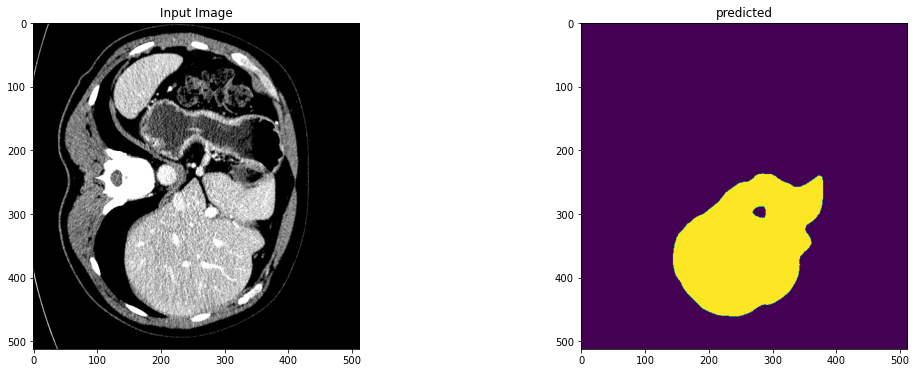

In [28]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.imshow(img[0, :, :, -34].detach().cpu(), cmap="gray")
plt.title("Input Image")
plt.subplot(1, 2, 2)
plt.imshow(test_ds[0]["label"][0, :, :, -34].detach().cpu())
plt.title("predicted")
plt.show()


In [39]:
import numpy as np
from torch.utils.tensorboard import SummaryWriter

# Assuming `SummaryWriter` object is already created elsewhere in your code

# Convert input image to numpy array and add channel dimension if necessary
input_image_np = img[0, :, :, -40].detach().cpu().numpy()
input_image_np = np.expand_dims(input_image_np, axis=-1) if len(input_image_np.shape) == 2 else input_image_np

# Convert label image to numpy array and add channel dimension if necessary
label_image_np = label[0, :, :, -40].detach().cpu().numpy()
label_image_np = np.expand_dims(label_image_np, axis=-1) if len(label_image_np.shape) == 2 else label_image_np

# Add input image to TensorBoard
writer.add_image('Input Image', input_image_np, dataformats='HWC', global_step=epoch)

# Add label image to TensorBoard
writer.add_image('Predicted Label', label_image_np, dataformats='HWC', global_step=epoch)


[2024-03-13T15:44:24Z INFO  rustboard_core::cli] Starting load cycle
[2024-03-13T15:44:24Z INFO  rustboard_core::cli] Finished load cycle (249.925µs)
[2024-03-13T15:44:29Z INFO  rustboard_core::cli] Starting load cycle
[2024-03-13T15:44:29Z INFO  rustboard_core::cli] Finished load cycle (248.245µs)


In [37]:
from torch.utils.tensorboard import SummaryWriter 
# Set up TensorBoard
log_dir = "/kaggle/working/logs"
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir)

In [33]:

!pip install pyngrok --quiet

In [34]:
from tensorboard import program
from pyngrok import ngrok
!ngrok authtoken 2dalZ5gDNZugbxC9sSTBv8uhXke_68JXcHoYwyCLs7u2NotAc

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml                                


In [40]:
from tensorboard import program
from pyngrok import ngrok
import os
import shutil

# Directories containing logs for IoU and Dice score
logs_dice_dir = '/kaggle/working/logs_dice'
logs_iou_dir = '/kaggle/working/logs_iou'

# Merged directory to contain logs for both IoU and Dice score
logs_combined_dir = '/kaggle/working/logs_combined'

# Create a combined directory if it doesn't exist
if not os.path.exists(logs_combined_dir):
    os.makedirs(logs_combined_dir)

# Copy logs from both directories to the combined directory
for file_name in os.listdir(logs_dice_dir):
    shutil.copy(os.path.join(logs_dice_dir, file_name), logs_combined_dir)
for file_name in os.listdir(logs_iou_dir):
    shutil.copy(os.path.join(logs_iou_dir, file_name), logs_combined_dir)
for file_name in os.listdir(log_dir):
    shutil.copy(os.path.join(log_dir, file_name), logs_combined_dir)    

# Setup TensorBoard with the combined logs directory
tb = program.TensorBoard()
tb.configure(argv=[None, '--logdir', logs_combined_dir])

# Start TensorBoard
tb_url = ngrok.connect(tb.launch())
print(f'TensorBoard URL: {tb_url}')

# Keep the program running to keep the ngrok tunnel open
input("Press Enter to exit...")


[2024-03-13T15:44:30Z INFO  rustboard_core::cli] Wrote port "43685" to /tmp/tensorboard_data_server_s1e7hclt/port
[2024-03-13T15:44:30Z INFO  rustboard_core::cli] Starting load cycle
[2024-03-13T15:44:30Z INFO  rustboard_core::cli] Finished load cycle (1.204281ms)

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784



TensorBoard URL: NgrokTunnel: "https://2e13-35-196-111-70.ngrok-free.app" -> "http://localhost:6007/"


[2024-03-13T15:44:34Z INFO  rustboard_core::cli] Starting load cycle
[2024-03-13T15:44:34Z INFO  rustboard_core::cli] Finished load cycle (821.445µs)
[2024-03-13T15:44:35Z INFO  rustboard_core::cli] Starting load cycle
[2024-03-13T15:44:35Z INFO  rustboard_core::cli] Finished load cycle (377.885µs)
[2024-03-13T15:44:39Z INFO  rustboard_core::cli] Starting load cycle
[2024-03-13T15:44:39Z INFO  rustboard_core::cli] Finished load cycle (214.721µs)
[2024-03-13T15:44:40Z INFO  rustboard_core::cli] Starting load cycle
[2024-03-13T15:44:40Z INFO  rustboard_core::cli] Finished load cycle (296.336µs)
[2024-03-13T15:44:44Z INFO  rustboard_core::cli] Starting load cycle
[2024-03-13T15:44:44Z INFO  rustboard_core::cli] Finished load cycle (361.796µs)
[2024-03-13T15:44:45Z INFO  rustboard_core::cli] Starting load cycle
[2024-03-13T15:44:45Z INFO  rustboard_core::cli] Finished load cycle (248.677µs)
[2024-03-13T15:44:49Z INFO  rustboard_core::cli] Starting load cycle
[2024-03-13T15:44:49Z INFO  rus

Press Enter to exit... e


'e'

[2024-03-13T15:45:24Z INFO  rustboard_core::cli] Starting load cycle
[2024-03-13T15:45:24Z INFO  rustboard_core::cli] Finished load cycle (283.22µs)
[2024-03-13T15:45:25Z INFO  rustboard_core::cli] Starting load cycle
[2024-03-13T15:45:25Z INFO  rustboard_core::cli] Finished load cycle (326.671µs)
[2024-03-13T15:45:29Z INFO  rustboard_core::cli] Starting load cycle
[2024-03-13T15:45:29Z INFO  rustboard_core::cli] Finished load cycle (375.556µs)
[2024-03-13T15:45:30Z INFO  rustboard_core::cli] Starting load cycle
[2024-03-13T15:45:30Z INFO  rustboard_core::cli] Finished load cycle (365.132µs)
[2024-03-13T15:45:34Z INFO  rustboard_core::cli] Starting load cycle
[2024-03-13T15:45:34Z INFO  rustboard_core::cli] Finished load cycle (259.277µs)
[2024-03-13T15:45:35Z INFO  rustboard_core::cli] Starting load cycle
[2024-03-13T15:45:35Z INFO  rustboard_core::cli] Finished load cycle (236.513µs)
[2024-03-13T15:45:39Z INFO  rustboard_core::cli] Starting load cycle
[2024-03-13T15:45:39Z INFO  rust